In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.model_selection import train_test_split
import os

In [2]:
!pip install --upgrade gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import gensim
print(gensim.__version__)

3.8.3


In [4]:
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 데이터 불러오기

In [5]:
train_data = pd.read_table('~/aiffel/exp7/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/exp7/sentiment_classification/data/ratings_test.txt')

In [6]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 토큰화를 진행합니다. 이과정에서 불용어를 제거합니다.

In [7]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','로서','로써','해서','하여','스런','던','유코']

def load_data(train_data, test_data, num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [8]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외
 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 데이터셋 안의 문장 길이 분포를 확인합니다.

In [11]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
print('리뷰의 표준편차 : ', np.std(num_tokens))

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.90494473709807
리뷰의 표준편차 :  12.78316546300724


# 이상치 한계선이라 여겨지는 평균 + 3표준편차로 최대길이를 설정합니다.

In [12]:
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  54
전체 문장의 0.9728676813129995%가 maxlen 설정값 이내에 포함됩니다. 


# 설정된 최대길이에 맞춰 Pre 패딩을 진행합니다.

In [13]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

print(X_train.shape)

(146182, 54)


-----------

# 세가지 모델을 구성하여 모델링을 진행하였습니다.

# Model 1 : 1 Layer LSTM
## LSTM을 한 레이어만 활용한 모델입니다.

In [14]:
vocab_size = 10000
word_vector_dim = 16

model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1.add(keras.layers.LSTM(256))
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               279552    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 505,601
Trainable params: 505,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
x_train_split, x_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 12)
print(x_train_split.shape)
print(y_train_split.shape)

(116945, 54)
(116945,)


In [16]:
model_1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history_1 = model_1.fit(x_train_split, y_train_split, epochs=5, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/5
1828/1828 [==============================] - 39s 20ms/step - loss: 0.4506 - accuracy: 0.7790 - val_loss: 0.3533 - val_accuracy: 0.8455
Epoch 2/5
1828/1828 [==============================] - 35s 19ms/step - loss: 0.3156 - accuracy: 0.8639 - val_loss: 0.3307 - val_accuracy: 0.8574
Epoch 3/5
1828/1828 [==============================] - 35s 19ms/step - loss: 0.2635 - accuracy: 0.8890 - val_loss: 0.3245 - val_accuracy: 0.8584
Epoch 4/5
1828/1828 [==============================] - 35s 19ms/step - loss: 0.2300 - accuracy: 0.9054 - val_loss: 0.3379 - val_accuracy: 0.8572
Epoch 5/5
1828/1828 [==============================] - 35s 19ms/step - loss: 0.2045 - accuracy: 0.9183 - val_loss: 0.3633 - val_accuracy: 0.8556


In [17]:
results_1 = model_1.evaluate(X_test,  y_test, verbose=2)

print(results_1)

1537/1537 - 8s - loss: 0.3595 - accuracy: 0.8548
[0.3595086336135864, 0.8547714352607727]


## 운이 좋게도 1번 모델부터 목표치인 85% 이상의 accuracy를 얻을 수 있었습니다.

In [18]:
history_1_dict = history_1.history
print(history_1_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


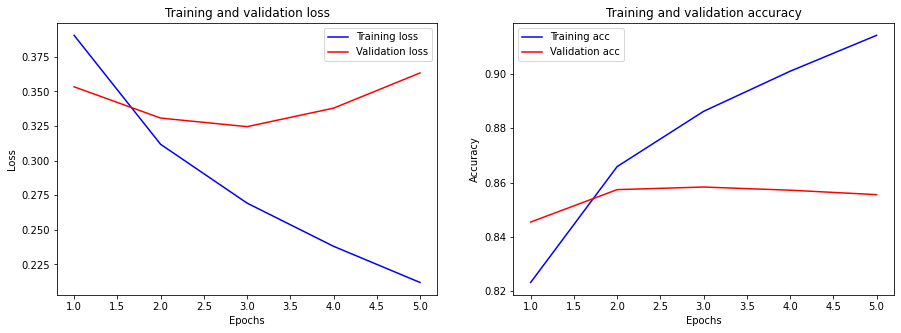

In [19]:
import matplotlib.pyplot as plt

acc = history_1_dict['accuracy']
val_acc = history_1_dict['val_accuracy']
loss = history_1_dict['loss']
val_loss = history_1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---------

# Model 2 : 2 Layer LSTM
## LSTM 레이어를 2개 사용하여 모델링을 진행하였습니다.  
## LSTM 레이어를 하나 사용하는 것 보다 좋은 성능이 나올 것으로 기대했습니다.

In [20]:
vocab_size = 10000
word_vector_dim = 16

model_2 = keras.Sequential()
model_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(keras.layers.LSTM(128, return_sequences = True))
model_2.add(keras.layers.Dense(128, activation='relu'))
model_2.add(keras.layers.LSTM(128, return_sequences = True))
model_2.add(keras.layers.Dense(128, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         74240     
_________________________________________________________________
dense_2 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           129       
Total params: 398,977
Trainable params: 398,977
Non-trainable params: 0
________________________________________________

In [21]:
model_2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history_2 = model_2.fit(x_train_split, y_train_split, epochs=5, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/5
1828/1828 [==============================] - 55s 28ms/step - loss: 0.6540 - accuracy: 0.5552 - val_loss: 0.6255 - val_accuracy: 0.5817
Epoch 2/5
1828/1828 [==============================] - 50s 28ms/step - loss: 0.6144 - accuracy: 0.5897 - val_loss: 0.6238 - val_accuracy: 0.5836
Epoch 3/5
1828/1828 [==============================] - 50s 28ms/step - loss: 0.6045 - accuracy: 0.5932 - val_loss: 0.6262 - val_accuracy: 0.5833
Epoch 4/5
1828/1828 [==============================] - 51s 28ms/step - loss: 0.5974 - accuracy: 0.5948 - val_loss: 0.6260 - val_accuracy: 0.5835
Epoch 5/5
1828/1828 [==============================] - 51s 28ms/step - loss: 0.5906 - accuracy: 0.6010 - val_loss: 0.6276 - val_accuracy: 0.5830


In [22]:
results_2 = model_2.evaluate(X_test,  y_test, verbose=2)

print(results_2)

1537/1537 - 12s - loss: 0.6258 - accuracy: 0.5873
[0.6257584095001221, 0.5873424410820007]


## LSTM 레이어를 하나 사용했을 때보다 높은 성능을 기대했으나 놀랍게도 기대에 턱없이 모자른 성능을 보여주었습니다.

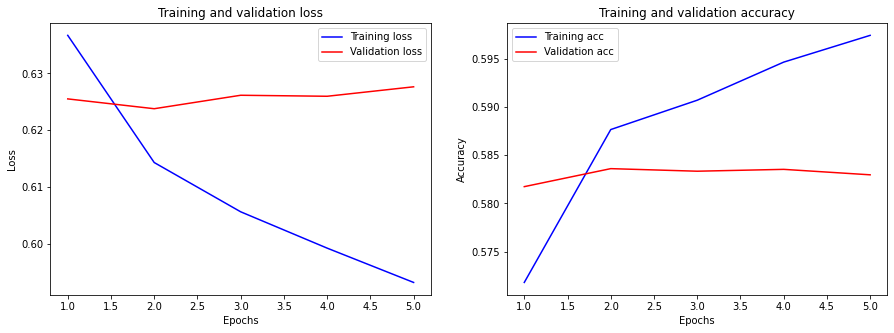

In [23]:
history_2_dict = history_2.history
acc = history_2_dict['accuracy']
val_acc = history_2_dict['val_accuracy']
loss = history_2_dict['loss']
val_loss = history_2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---------

# Model 3 : 1-D CNN
## RNN 대신에 CNN 방식을 활용한 모델링을 진행해보았습니다.
## RNN 보다는 좀 더 성능이 낮을 것으로 예상되나 모델링 속도는 더욱 빠를 것으로 예상됩니다. 따라서 15 epochs로 설정하여 모델링을 진행해 보았습니다.

In [24]:
vocab_size = 10000
word_vector_dim = 16

model_3 = keras.Sequential()
model_3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_3.add(keras.layers.MaxPooling1D(5))
model_3.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_3.add(keras.layers.GlobalMaxPooling1D())
model_3.add(keras.layers.Dense(8, activation='relu'))
model_3.add(keras.layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [25]:
model_3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history_3 = model_3.fit(x_train_split, y_train_split, epochs=15, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/15
1828/1828 [==============================] - 17s 7ms/step - loss: 0.5055 - accuracy: 0.7325 - val_loss: 0.3945 - val_accuracy: 0.8179
Epoch 2/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.3313 - accuracy: 0.8532 - val_loss: 0.3878 - val_accuracy: 0.8226
Epoch 3/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.2839 - accuracy: 0.8790 - val_loss: 0.4015 - val_accuracy: 0.8188
Epoch 4/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.2361 - accuracy: 0.9013 - val_loss: 0.4328 - val_accuracy: 0.8164
Epoch 5/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.1970 - accuracy: 0.9202 - val_loss: 0.4724 - val_accuracy: 0.8097
Epoch 6/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.1666 - accuracy: 0.9327 - val_loss: 0.5207 - val_accuracy: 0.8068
Epoch 7/15
1828/1828 [==============================] - 10s 6ms/step - loss: 0.1427 - accuracy: 0.9434 - val_loss: 0.5696 - val_ac

## 예상대로 하나의 epoch마다 모델링에 더 적은 시간이 든다는 것을 확인할 수 있습니다.

In [26]:
results_3 = model_3.evaluate(X_test,  y_test, verbose=2)

print(results_3)

1537/1537 - 4s - loss: 0.9832 - accuracy: 0.7902
[0.9832096695899963, 0.7901824712753296]


## accuracy 또한 기존의 RNN 모델에 비해 조금 떨어지는 것을 볼 수 있었습니다.
## 다만 LSTM layer를 2개 활용한 모델 2보다는 더 높은 accuracy를 보여주고 있습니다.

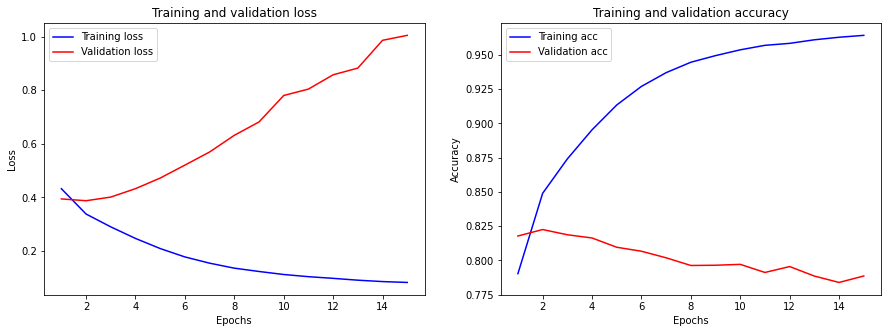

In [27]:
history_3_dict = history_3.history
acc = history_3_dict['accuracy']
val_acc = history_3_dict['val_accuracy']
loss = history_3_dict['loss']
val_loss = history_3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---------------------

# Gensim을 활용하여 자체학습된 임베딩 레이어를 분석해보았습니다.

In [28]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/exp7/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [30]:
vector = word_vectors['추천']
vector

array([ 0.11745215,  0.07718747,  0.14873166,  0.00552875, -0.08800296,
       -0.02088217, -0.08179249, -0.06218768, -0.01443339, -0.07600384,
       -0.10769683,  0.11350792, -0.0522565 , -0.05771133,  0.10890085,
       -0.0065195 ], dtype=float32)

## 영화의 평과 직접적으로 관련될 수 있는 단어 위주로 유사 벡터를 구했습니다.

In [31]:
word_vectors.similar_by_word('추천')

[('저격', 0.9496068954467773),
 ('해져서', 0.9451103806495667),
 ('낙원', 0.943535566329956),
 ('고조', 0.9426010847091675),
 ('달콤', 0.9423448443412781),
 ('발킬머', 0.9411572813987732),
 ('본받', 0.9383111596107483),
 ('애인', 0.9371739625930786),
 ('억압', 0.9369133710861206),
 ('중사', 0.9354552030563354)]

## 이 과정에서 의미를 알 수 없는 단어가 나온 경우 토큰화 과정에 불용어로 추가하여 다시 모델링을 진행하고 임베딩 레이어 분석을 진행했습니다.

-----------------------------

# 한국어 Word2Vec을 활용한 성능 향상을 시도하였습니다.

In [32]:
word2vec_path = os.getenv('HOME')+'/aiffel/exp7/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [33]:
vector = word2vec['추천']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.21245585, -0.76455975,  1.2335763 , -2.0687602 ,  0.11830104,
       -0.54881305, -1.1947731 ,  0.3467694 , -1.0311009 , -0.3603907 ,
        1.3440485 , -0.4072002 ,  1.1131706 , -0.9551345 , -0.7064215 ,
       -0.1686603 , -0.58696073, -1.4859254 ,  0.05223045, -0.23236327,
        0.6323806 , -1.1020958 , -1.2635112 ,  0.6220531 ,  0.17838949,
       -0.70615005, -1.3628044 , -1.4818763 , -0.18965532,  0.11690602,
       -0.09560227, -0.39899632,  1.0731212 , -0.63874424,  0.017969  ,
        0.98583263,  1.3941766 ,  0.08089745, -0.81685823, -0.7022943 ,
       -0.5008832 , -0.54513174,  0.34584457, -1.7315279 , -0.24291196,
        0.6328651 ,  1.4537793 , -0.7011548 ,  0.80850524,  0.74069935,
       -0.9272299 , -1.335555  , -1.1335523 ,  3.2529519 ,  0.6823866 ,
       -1.4942434 ,  3.213415  ,  1.0216335 , -0.4152105 , -0.11520938,
       -0.08406533, -0.49404764, -1.7769778 ,  0.19683318,  0.48151487,
       -0.67674905, -1.5347718 ,  0.17763563, -0.6901806 , -0.71

In [34]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


# 가장 성능이 높았던 Model 1에 한국어 Word2Vec을 적용해 보기로 했습니다.

In [39]:
model_word2vec = keras.Sequential()
model_word2vec.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))  
model_word2vec.add(keras.layers.LSTM(256))
model_word2vec.add(keras.layers.Dense(256, activation='relu'))
model_word2vec.add(keras.layers.Dense(1, activation='sigmoid'))

model_word2vec.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 54, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 2,534,017
Trainable params: 2,534,017
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_word2vec.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history_word2vec = model_word2vec.fit(x_train_split, y_train_split, epochs=10, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
1828/1828 [==============================] - 57s 30ms/step - loss: 0.4551 - accuracy: 0.7764 - val_loss: 0.3294 - val_accuracy: 0.8553
Epoch 2/10
1828/1828 [==============================] - 55s 30ms/step - loss: 0.2820 - accuracy: 0.8817 - val_loss: 0.3228 - val_accuracy: 0.8616
Epoch 3/10
1828/1828 [==============================] - 55s 30ms/step - loss: 0.2276 - accuracy: 0.9069 - val_loss: 0.3211 - val_accuracy: 0.8677
Epoch 4/10
1828/1828 [==============================] - 55s 30ms/step - loss: 0.1765 - accuracy: 0.9291 - val_loss: 0.3457 - val_accuracy: 0.8657
Epoch 5/10
1828/1828 [==============================] - 55s 30ms/step - loss: 0.1254 - accuracy: 0.9516 - val_loss: 0.4129 - val_accuracy: 0.8620
Epoch 6/10
1828/1828 [==============================] - 55s 30ms/step - loss: 0.0880 - accuracy: 0.9670 - val_loss: 0.5059 - val_accuracy: 0.8602
Epoch 7/10
1828/1828 [==============================] - 55s 30ms/step - loss: 0.0609 - accuracy: 0.9772 - val_loss: 0.6129 -

In [41]:
results_word2vec = model_word2vec.evaluate(X_test,  y_test, verbose=2)

print(results_word2vec)

1537/1537 - 9s - loss: 0.8077 - accuracy: 0.8585
[0.8076536059379578, 0.858494222164154]


# 유의미한 성능향상이 있을 것이라는 기대와 달리 미미한 성능향상을 보여주고 있습니다.

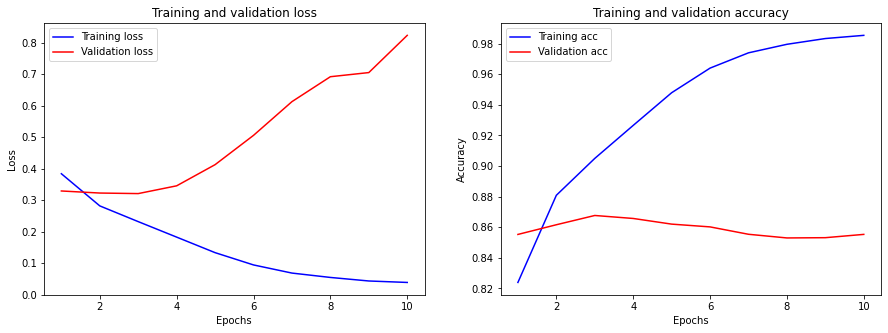

In [42]:
history_word2vec_dict = history_word2vec.history
acc = history_word2vec_dict['accuracy']
val_acc = history_word2vec_dict['val_accuracy']
loss = history_word2vec_dict['loss']
val_loss = history_word2vec_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

------------------------

# 노드에는 없지만 모델링이 제대로 되었는지 확인해보고자 학습된 모델을 통해 리뷰를 긍정과 부정으로 분류해 주는 함수를 생성해보았습니다.
# 해당 함수는 AIFFEL 명예의전당을 참고하였습니다.

In [52]:
def sentiment_predict():
    new_sentence = str(input('영화 리뷰를 남겨주세요 : '))
    new_sentence = tokenizer.morphs(new_sentence)
    new_sentence.insert(0, '<BOS>')
    new_sentence = [word for word in new_sentence if not word in stopwords]

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    new_sentence = wordlist_to_indexlist(new_sentence)
    new_sentence = [new_sentence]

    new_sentence = keras.preprocessing.sequence.pad_sequences(new_sentence, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
    
    score = float(model_word2vec.predict(new_sentence))
    
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [53]:
sentiment_predict()

영화 리뷰를 남겨주세요 : 와 이번 영화 진짜 대박 ㅠㅠㅠ
97.94% 확률로 긍정 리뷰입니다.



In [47]:
sentiment_predict()

영화 리뷰를 남겨주세요 : 꼭 보세요. 인생명작!
99.95% 확률로 긍정 리뷰입니다.



In [48]:
sentiment_predict()

영화 리뷰를 남겨주세요 : 환불 안 되나요 이거 ㅠㅠㅠ
100.00% 확률로 부정 리뷰입니다.



In [49]:
sentiment_predict()

영화 리뷰를 남겨주세요 : 킬링타임용
99.99% 확률로 부정 리뷰입니다.



# 환불이나 킬링타임 같은 단어에서도 기대보다 분류가 잘 되는 모습을 확인할 수 있었습니다.